In [2]:
import pandas as pd
import datetime
import numpy as np
#import plotly as pl

#import plotly.graph_objs as go
#from plotly.offline import init_notebook_mode, iplot
#from plotly.subplots import make_subplots
#init_notebook_mode()

import CoreTraidMath 
import CoreDraw


In [3]:
class coreIndicator():
    def __init__(self,
                 data=pd.DataFrame(),
                 options={},
                 showMode='None',
                ):
        '''
        showMode = None/Ind/PartOf        
        '''
        self.data=data
        self.showMode=showMode
        self.options=options
        self.overlayInd=None #True/False
        self.ans=None
        self.figDict=None
        
    def getAns(self,data=None):
        if type(data)!=type(None):
            self.data=data
        self.ans=self.getCalculate()
        if self.showMode=='Ind' or self.showMode=='PartOf':
            self.figDict=self.getFigDict()
            if self.showMode=='Ind':
                self.getFig()
        return self.ans
    def getFig(self,row=1):
        CoreDraw.coreDraw(self.figDict,True)
    def getCalculate(self):
        return "Error"
    def getFigDict(self):
        return "Error"

class indicatorAgrigator():
    '''
    Тема чисто для отладки
    jj=indicatorAgrigator().runAll([o1,o2],df_candle[:30])
    #jj.createIndFromList([o1,o2])
    #jj.calculateInd(df_candle[:30])
    
    '''
    def __init__(self):
        self.indList=None
        self.data=None
    def createInd(self,classDict):
        return classDict['name'](
                options=classDict['params'],
                showMode=classDict['showMode']
            )
        
        
    def createIndFromList(self,indList):
        self.indList=indList
        ans=[]
        for i in self.indList:
            ans.append(self.createInd(i))
        self.indList=ans
        return ans
    
    def calculateInd(self,data):
        self.data=data
        for i in self.indList:
            #i.getAns(data)
            i.data=self.data
            i.ans=i.getCalculate()
            i.figDict=i.getFigDict()
            #i.getFig()
    def agrigateFig(self):
        req=[[]]
        
        for i in self.indList:
            if i.overlayInd==True:
                req[0].append(i)
            else:
                req.append([i])
        CoreDraw.agrigateFig(req,True)
    def runAll(self,indList,df,needDraw=False):
        self.createIndFromList(indList)
        self.calculateInd(df)
        if needDraw:
            self.agrigateFig()

        
        

In [4]:
class ind_BB(coreIndicator):
    
    def getCalculate(self):
        self.overlayInd=True
        ans={}
        opMA={'dataType':'ohcl',
            'action':'findMean',
            'actionOptions':{
                'MeanType':self.options['MeanType'],
                'valueType':self.options['valueType'],
                'window':self.options['window']
            }
        }
        ans['BB']=CoreTraidMath.CoreMath(self.data,opMA).ans
        opSTD={'dataType':'ohcl',
            'action':'findSTD',
            'actionOptions':{'valueType':self.options['valueType'],'window':self.options['window']}
        }
        ans['STD']=CoreTraidMath.CoreMath(self.data,opSTD).ans
        ans['pSTD']=ans['BB']+ans['STD']*self.options['kDev']
        ans['mSTD']=ans['BB']-ans['STD']*self.options['kDev']
        ans['x']=np.array(self.data['date'][self.options['window']-1:].to_list())
        return ans
    def getFigDict(self,row=1):
        req=[]
        
        req.append({
            'vtype':'Scatter',
            'df':pd.DataFrame(
                {'value':self.ans['BB'],'date':self.ans['x']}) ,
            'row':row,
            'col':1,
            'name':'BB'
            
        })
        req.append({
            'vtype':'Scatter',
            'df':pd.DataFrame(
                {'value':self.ans['pSTD'],'date':self.ans['x']}) ,
            'row':row,
            'col':1,
            'name':'pSTD'
            
        })
        req.append({
            'vtype':'Scatter',
            'df':pd.DataFrame(
                {'value':self.ans['mSTD'],'date':self.ans['x']}) ,
            'row':row,
            'col':1,
            'name':'mSTD'
            
        })
        
        return req

In [5]:
class ind_OCHL(coreIndicator):
    def getCalculate(self):
        self.overlayInd=True
    def getFigDict(self,row=1):
        req=[]
        
        req.append({
                'vtype':'OCHL',
                'df':self.data,
                'row':1,
                'col':1,
                'name':'OHCL'

        })
        return req

In [7]:
df_candle = pd.read_csv("../data/EURUSD_price_candlestick.csv")
df_candle.rename(columns={'timestamp': 'date'}, inplace=True)
df_candle

date     open    close     high      low
0      2020-09-01 03:00:00+03:00  1.19370  1.19388  1.19391  1.19368
1      2020-09-01 03:00:05+03:00  1.19387  1.19388  1.19391  1.19383
2      2020-09-01 03:00:10+03:00  1.19387  1.19384  1.19389  1.19382
3      2020-09-01 03:00:15+03:00  1.19384  1.19384  1.19386  1.19382
4      2020-09-01 03:00:20+03:00  1.19387  1.19390  1.19391  1.19383
...                          ...      ...      ...      ...      ...
99995  2020-09-06 21:52:55+03:00  1.18382  1.18382  1.18393  1.18371
99996  2020-09-06 21:53:00+03:00  1.18382  1.18382  1.18393  1.18371
99997  2020-09-06 21:53:05+03:00  1.18382  1.18382  1.18393  1.18371
99998  2020-09-06 21:53:10+03:00  1.18382  1.18382  1.18393  1.18371
99999  2020-09-06 21:53:15+03:00  1.18382  1.18382  1.18393  1.18371

[100000 rows x 5 columns]

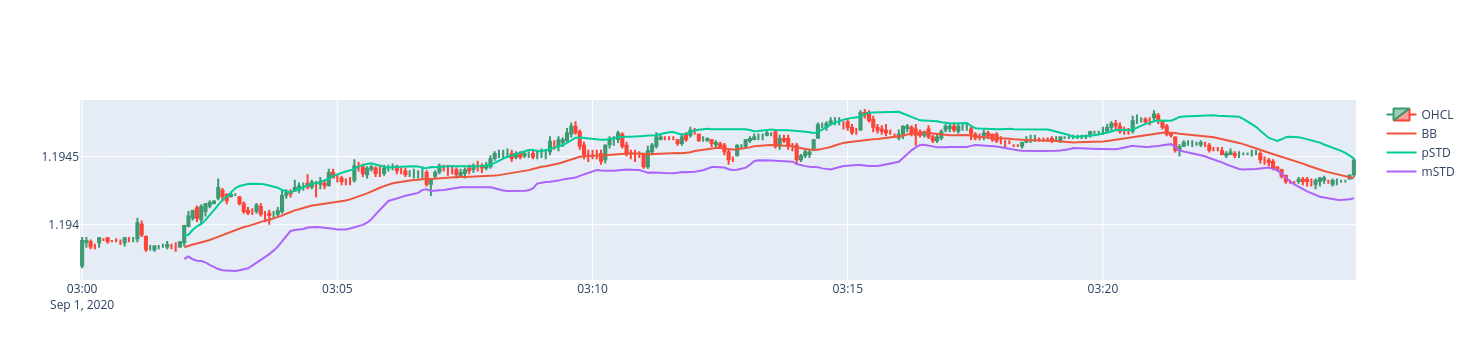

In [8]:
o1={
    'name':ind_OCHL,
    'params':{},
    'showMode':'PartOf',
}
o2={
    'name':ind_BB,
    'params':{'MeanType':'SMA','window':25,'valueType':'low','kDev':2},
    'showMode':'PartOf',
}
jj=indicatorAgrigator().runAll([o1,o2],df_candle[:300],True)
#jj.createIndFromList([o1,o2])
#jj.calculateInd(df_candle[:30])

In [9]:
op={'MeanType':'SMA','window':5,'valueType':'low','kDev':2}
a=ind_BB(df_candle[:100],op,'PartOf')

In [10]:
a.getAns()

{'BB': array([1.193796, 1.193836, 1.193842, 1.193852, 1.193862, 1.193866,
        1.193858, 1.19386 , 1.19386 , 1.19386 , 1.193872, 1.193864,
        1.193852, 1.193838, 1.193828, 1.193812, 1.193816, 1.193818,
        1.193818, 1.19382 , 1.193822, 1.193854, 1.193896, 1.19394 ,
        1.193974, 1.194018, 1.194046, 1.19407 , 1.194102, 1.194136,
        1.194154, 1.19417 , 1.194182, 1.194174, 1.194156, 1.19414 ,
        1.194114, 1.194088, 1.194072, 1.19406 , 1.194046, 1.194042,
        1.194038, 1.194042, 1.194076, 1.194116, 1.194154, 1.194188,
        1.194222, 1.194236, 1.194248, 1.19424 , 1.194246, 1.194248,
        1.194252, 1.194268, 1.19429 , 1.194296, 1.194302, 1.194304,
        1.194298, 1.194314, 1.194326, 1.194336, 1.194356, 1.194364,
        1.194356, 1.194358, 1.194368, 1.19437 , 1.194374, 1.194378,
        1.194376, 1.194368, 1.194356, 1.19435 , 1.194344, 1.19433 ,
        1.194302, 1.194302, 1.194308, 1.194318, 1.194334, 1.194366,
        1.194366, 1.194362, 1.194352, 1.19

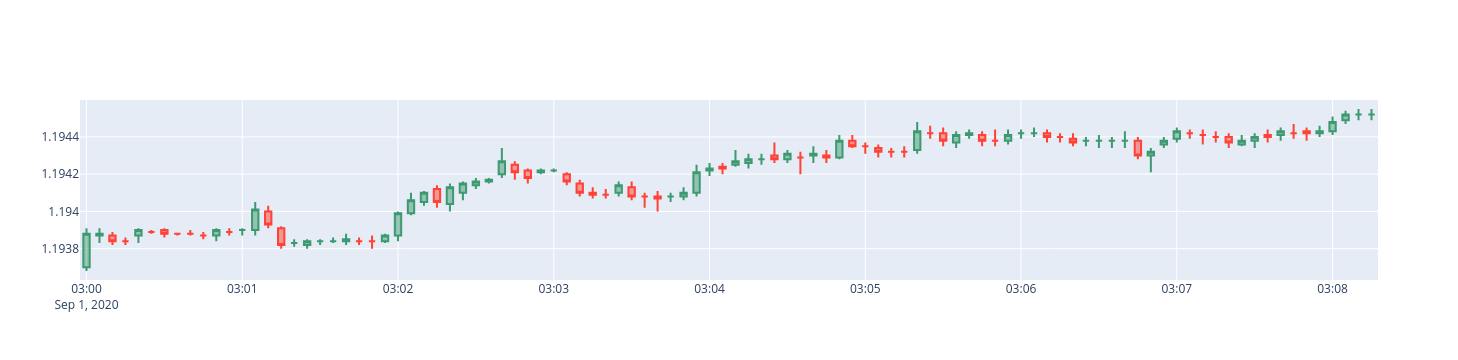

In [11]:
b=ind_OCHL(df_candle[:30],{},'Ind')
b.getAns(df_candle[:100])

In [12]:
opc={'MeanType':'SMA','window':20,'valueType':'low','kDev':2}
c=ind_BB(df_candle[:100],opc,'PartOf')
c.getAns()

{'BB': array([1.1938365, 1.1938435, 1.193843 , 1.193842 , 1.1938425, 1.193843 ,
        1.193848 , 1.1938565, 1.193864 , 1.1938705, 1.193881 , 1.193895 ,
        1.193909 , 1.1939245, 1.1939395, 1.1939515, 1.1939715, 1.1939915,
        1.1940085, 1.1940215, 1.1940335, 1.194046 , 1.194059 , 1.194072 ,
        1.1940815, 1.1940895, 1.194093 , 1.1940945, 1.1940975, 1.194107 ,
        1.194114 , 1.19412  , 1.194124 , 1.1941275, 1.194132 , 1.1941375,
        1.1941375, 1.19414  , 1.194146 , 1.194156 , 1.1941695, 1.1941815,
        1.194192 , 1.1942035, 1.194217 , 1.1942325, 1.1942495, 1.194264 ,
        1.194277 , 1.194287 , 1.1942945, 1.1943   , 1.1943065, 1.1943135,
        1.1943205, 1.194326 , 1.1943345, 1.194339 , 1.1943435, 1.1943465,
        1.1943465, 1.194348 , 1.1943475, 1.1943435, 1.194346 , 1.194349 ,
        1.194349 , 1.1943495, 1.194351 , 1.1943485, 1.1943485, 1.194348 ,
        1.1943485, 1.194348 , 1.1943475, 1.194348 , 1.1943495, 1.1943525,
        1.1943585, 1.194366 , 1.

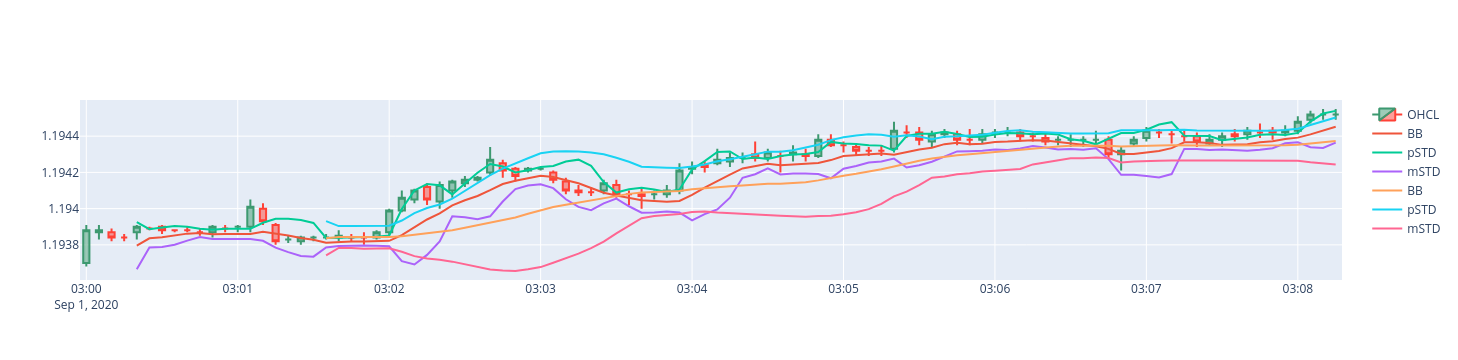

In [13]:
hhh = CoreDraw.agrigateFig([[b,a,c]],True)

In [14]:
import indicators

In [15]:
op_1={'MeanType':'SMA','window':5,'valueType':'low','kDev':2}
test_1=indicators.ind_BB(df_candle[:100],op)
test_1.getAns()

{'BB': array([1.193796, 1.193836, 1.193842, 1.193852, 1.193862, 1.193866,
        1.193858, 1.19386 , 1.19386 , 1.19386 , 1.193872, 1.193864,
        1.193852, 1.193838, 1.193828, 1.193812, 1.193816, 1.193818,
        1.193818, 1.19382 , 1.193822, 1.193854, 1.193896, 1.19394 ,
        1.193974, 1.194018, 1.194046, 1.19407 , 1.194102, 1.194136,
        1.194154, 1.19417 , 1.194182, 1.194174, 1.194156, 1.19414 ,
        1.194114, 1.194088, 1.194072, 1.19406 , 1.194046, 1.194042,
        1.194038, 1.194042, 1.194076, 1.194116, 1.194154, 1.194188,
        1.194222, 1.194236, 1.194248, 1.19424 , 1.194246, 1.194248,
        1.194252, 1.194268, 1.19429 , 1.194296, 1.194302, 1.194304,
        1.194298, 1.194314, 1.194326, 1.194336, 1.194356, 1.194364,
        1.194356, 1.194358, 1.194368, 1.19437 , 1.194374, 1.194378,
        1.194376, 1.194368, 1.194356, 1.19435 , 1.194344, 1.19433 ,
        1.194302, 1.194302, 1.194308, 1.194318, 1.194334, 1.194366,
        1.194366, 1.194362, 1.194352, 1.19